In [2]:
import pandas as pd
from pathlib import Path
from datetime import date
import time

# Configuración de rutas
BASE_PATH = Path("..").resolve().parent
FECHA = date.today().isoformat()
BT_FILE = BASE_PATH / "reports" / "backtesting" / f"bt_heuristicas_2025-05-27.csv"

def cargar_csv_optimizado(archivo_path):
    """
    Función optimizada para cargar CSV con mejor rendimiento
    """
    print(f"🚀 Cargando archivo: {archivo_path}")
    start_time = time.time()
    
    # OPTIMIZACIÓN 1: Especificar tipos de datos y usar motor más rápido
    dtype_dict = {
        # Ajusta estos tipos según tus columnas reales
        'symbol': 'category',  # Para strings repetitivos
        'strategy': 'category',
        'side': 'category',
        'resultado': 'float32',  # Usa float32 en lugar de float64 si no necesitas precisión extra
        'pnl': 'float32',
        'qty': 'int32',  # int32 en lugar de int64
    }
    
    try:
        # OPTIMIZACIÓN 2: Leer con parámetros optimizados
        df = pd.read_csv(
            archivo_path,
            dtype=dtype_dict,  # Especificar tipos reduce memoria y mejora velocidad
            engine='c',  # Motor C es más rápido que python
            low_memory=False,  # Evita warnings de tipos mixtos
            parse_dates=['fecha_entry', 'fecha_exit'],  # Parsear fechas directamente
            date_parser=pd.to_datetime,  # Parser optimizado
            na_filter=True,  # Manejar valores nulos eficientemente
        )
        
    except (KeyError, ValueError) as e:
        print(f"⚠️  Error con tipos específicos, usando lectura estándar optimizada...")
        # Fallback: lectura optimizada sin tipos específicos
        df = pd.read_csv(
            archivo_path,
            engine='c',
            low_memory=False,
            parse_dates=['fecha_entry', 'fecha_exit'],
            date_parser=pd.to_datetime,
        )
    
    # OPTIMIZACIÓN 3: Reducir memoria después de cargar
    df = reducir_memoria_df(df)
    
    end_time = time.time()
    print(f"✅ Archivo cargado en {end_time - start_time:.2f} segundos")
    print(f"📊 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    return df

def reducir_memoria_df(df):
    """
    Reduce el uso de memoria del DataFrame optimizando tipos de datos
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Optimizar enteros
            if str(col_type)[:3] == 'int':
                if c_min > -128 and c_max < 127:
                    df[col] = df[col].astype('int8')
                elif c_min > -32768 and c_max < 32767:
                    df[col] = df[col].astype('int16')
                elif c_min > -2147483648 and c_max < 2147483647:
                    df[col] = df[col].astype('int32')
                    
            # Optimizar flotantes
            elif str(col_type)[:5] == 'float':
                if c_min > -3.4e38 and c_max < 3.4e38:
                    df[col] = df[col].astype('float32')
        
        # Convertir strings repetitivos a categorías
        elif col_type == object:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:  # Si menos del 50% son únicos
                df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"🔧 Memoria reducida de {start_mem:.1f}MB a {end_mem:.1f}MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reducción)")
    
    return df

# EJECUCIÓN PRINCIPAL
if __name__ == "__main__":
    # Verificar que el archivo existe
    if not BT_FILE.exists():
        print(f"❌ Archivo no encontrado: {BT_FILE}")
        print("🔍 Archivos disponibles en el directorio:")
        bt_dir = BT_FILE.parent
        if bt_dir.exists():
            for file in bt_dir.glob("*.csv"):
                print(f"   - {file.name}")
    else:
        # Cargar con optimizaciones
        df = cargar_csv_optimizado(BT_FILE)
        
        # Información básica
        print(f"\n📈 RESUMEN DEL DATASET:")
        print(f"Total operaciones: {len(df):,}")
        print(f"Columnas: {list(df.columns)}")
        print(f"Rango de fechas: {df['fecha_entry'].min()} a {df['fecha_entry'].max()}")
        
        # Mostrar primeras filas
        print(f"\n🔍 PRIMERAS 3 FILAS:")
        print(df.head(3).to_string())
        
        # Info adicional útil para análisis
        print(f"\n📊 INFO ADICIONAL:")
        print(f"Tipos de datos:")
        print(df.dtypes)
        print(f"\nValores nulos por columna:")
        print(df.isnull().sum())

# BONUS: Función para lectura chunked si el archivo es MUY grande (>1GB)
def cargar_csv_chunked(archivo_path, chunk_size=10000):
    """
    Para archivos extremadamente grandes, carga por chunks
    """
    chunks = []
    for chunk in pd.read_csv(archivo_path, chunksize=chunk_size, engine='c'):
        # Procesar cada chunk si es necesario
        chunks.append(chunk)
    
    return pd.concat(chunks, ignore_index=True)


🚀 Cargando archivo: D:\trading\reports\backtesting\bt_heuristicas_2025-05-27.csv


C:\Users\leant\AppData\Local\Temp\ipykernel_21132\3132209789.py:31: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


🔧 Memoria reducida de 55.1MB a 7.7MB (86.0% reducción)
✅ Archivo cargado en 1.46 segundos
📊 Memoria utilizada: 7.7 MB

📈 RESUMEN DEL DATASET:
Total operaciones: 244,413
Columnas: ['simbolo', 'estrategia', 'fecha_entry', 'fecha_exit', 'signal', 'entry', 'exit', 'retorno', 'tp_hit', 'sl_hit']
Rango de fechas: 2005-07-14 00:00:00 a 2025-05-23 00:00:00

🔍 PRIMERAS 3 FILAS:
  simbolo         estrategia fecha_entry fecha_exit signal      entry       exit  retorno  tp_hit  sl_hit
0     AEP  gap_open_strategy  2006-10-10 2006-10-18    buy  39.310001  41.189999   0.0478    True   False
1     AEP  gap_open_strategy  2007-08-06 2007-08-14    buy  46.310001  44.930000  -0.0298   False    True
2     AEP  gap_open_strategy  2007-08-09 2007-08-14   sell  46.970001  44.930000   0.0434    True   False

📊 INFO ADICIONAL:
Tipos de datos:
simbolo              category
estrategia           category
fecha_entry    datetime64[ns]
fecha_exit     datetime64[ns]
signal               category
entry              

🔄 Calculando métricas por símbolo...
✅ 50 símbolos con al menos 30 trades
🏆 Top 50 símbolos seleccionados
📊 RESUMEN EJECUTIVO - TOP SÍMBOLOS
Total símbolos analizados: 50
Top símbolos seleccionados: 50

📈 MÉTRICAS PROMEDIO (TOP 50):
Winrate promedio: 46.1%
Profit Factor promedio: 1.14
Sharpe promedio: 0.05
Retorno medio: 0.002
Trades promedio: 4888

🏅 TOP 5 SÍMBOLOS:
simbolo  score  winrate  profit_factor  retorno_medio  n_trades
  BTSGU  2.294    0.475          1.365          0.006       751
  MCHPP  2.270    0.543          1.353          0.010        92
    TPG  1.958    0.460          1.332          0.006      1823
  HBANM  1.953    0.502          1.350          0.003      1650
   RPRX  1.777    0.474          1.295          0.004      2222


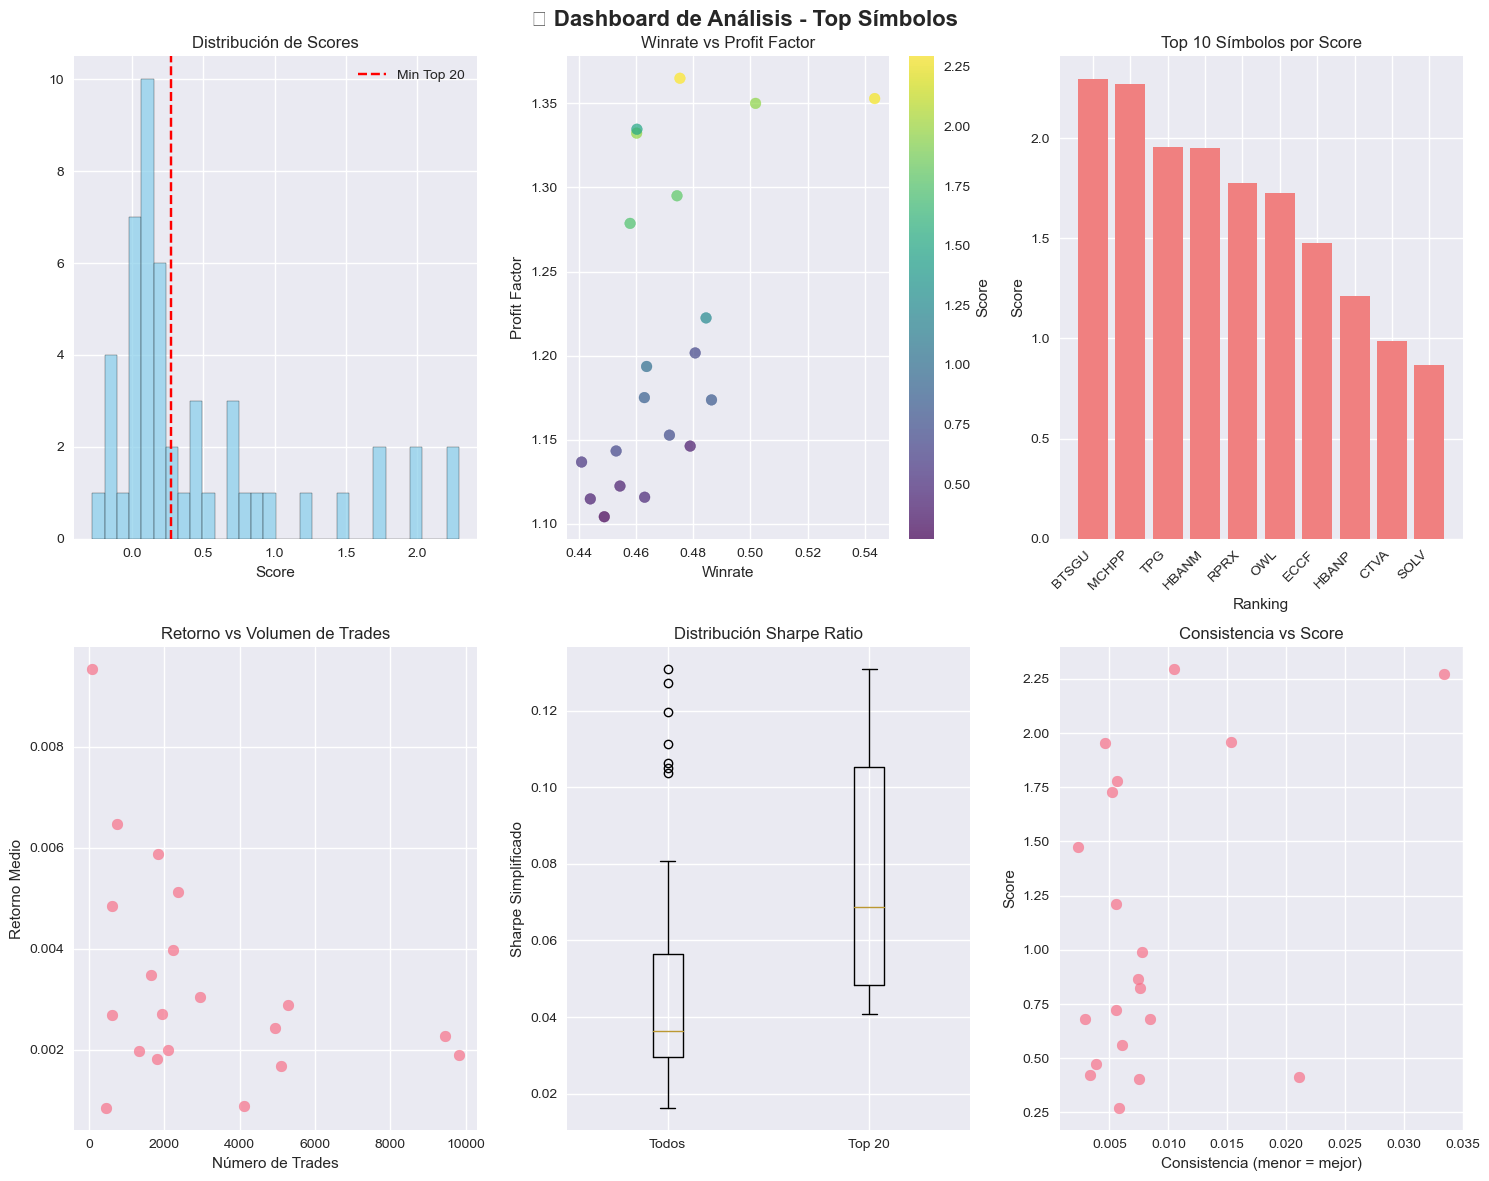

✅ Resultados exportados a: top_simbolos_analysis_20250527_232001.xlsx
🚀 Código listo para usar. Ejecuta: analizador = ejecutar_analisis_completo(df)


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class AnalizadorMetricas:
    """
    Clase optimizada para análisis de métricas de trading
    """
    
    def __init__(self, df):
        self.df = df
        self.resumen = None
        self.top_simbolos = None
        
    def calc_metricas_avanzadas(self, min_trades=30):
        """
        Calcula métricas avanzadas de trading con optimizaciones
        """
        print("🔄 Calculando métricas por símbolo...")
        
        # Agrupación optimizada usando múltiples funciones
        agg_dict = {
            'retorno': [
                'count',
                'mean', 
                'median',
                'std',
                lambda x: x[x > 0].sum(),  # retorno_pos
                lambda x: abs(x[x < 0].sum()),  # retorno_neg
                lambda x: (x > 0).mean(),  # winrate
                lambda x: len(x[x > 0]),  # trades_ganadores
                lambda x: len(x[x < 0]),  # trades_perdedores
                'max',  # mejor_trade
                'min'   # peor_trade
            ],
            'estrategia': 'nunique'
        }
        
        resumen = self.df.groupby("simbolo").agg(agg_dict)
        
        # Aplanar nombres de columnas
        resumen.columns = [
            'n_trades', 'retorno_medio', 'retorno_mediana', 'retorno_std',
            'retorno_pos', 'retorno_neg', 'winrate', 'trades_ganadores', 
            'trades_perdedores', 'mejor_trade', 'peor_trade', 'estrategias_usadas'
        ]
        
        resumen = resumen.reset_index()
        
        # Métricas derivadas
        resumen['profit_factor'] = resumen['retorno_pos'] / resumen['retorno_neg'].replace(0, np.nan)
        resumen['sharpe_simplificado'] = resumen['retorno_medio'] / resumen['retorno_std']
        resumen['avg_win'] = resumen['retorno_pos'] / resumen['trades_ganadores'].replace(0, np.nan)
        resumen['avg_loss'] = resumen['retorno_neg'] / resumen['trades_perdedores'].replace(0, np.nan)
        resumen['reward_risk_ratio'] = resumen['avg_win'] / resumen['avg_loss']
        
        # Consistencia entre estrategias
        consistencia = (
            self.df.groupby(["simbolo", "estrategia"])["retorno"]
            .mean()
            .groupby("simbolo")
            .std()
            .rename("consistencia")
        )
        
        resumen = resumen.merge(consistencia, on="simbolo", how="left")
        
        # Filtrar por mínimo de trades
        self.resumen = resumen.query(f"n_trades >= {min_trades}").copy()
        
        print(f"✅ {len(self.resumen)} símbolos con al menos {min_trades} trades")
        return self.resumen
    
    def calcular_score_robusto(self, pesos=None):
        """
        Calcula score combinado con normalización robusta
        """
        if pesos is None:
            pesos = {
                'sharpe': 0.25,
                'profit_factor': 0.20,
                'winrate': 0.20,
                'retorno_medio': 0.15,
                'reward_risk': 0.10,
                'consistencia': -0.10  # Penaliza inconsistencia
            }
        
        def normalizar_robusto(serie):
            """Normalización robusta usando percentiles"""
            q25, q75 = serie.quantile([0.25, 0.75])
            iqr = q75 - q25
            if iqr == 0:
                return serie * 0  # Si no hay variación, retorna 0
            return (serie - q25) / iqr
        
        # Normalizar métricas
        metricas_norm = pd.DataFrame(index=self.resumen.index)
        metricas_norm['sharpe_norm'] = normalizar_robusto(self.resumen['sharpe_simplificado'].fillna(0))
        metricas_norm['pf_norm'] = normalizar_robusto(self.resumen['profit_factor'].fillna(1))
        metricas_norm['winrate_norm'] = normalizar_robusto(self.resumen['winrate'])
        metricas_norm['retorno_norm'] = normalizar_robusto(self.resumen['retorno_medio'])
        metricas_norm['rr_norm'] = normalizar_robusto(self.resumen['reward_risk_ratio'].fillna(1))
        metricas_norm['consist_norm'] = normalizar_robusto(self.resumen['consistencia'].fillna(0))
        
        # Calcular score ponderado
        self.resumen['score'] = (
            pesos['sharpe'] * metricas_norm['sharpe_norm'] +
            pesos['profit_factor'] * metricas_norm['pf_norm'] +
            pesos['winrate'] * metricas_norm['winrate_norm'] +
            pesos['retorno_medio'] * metricas_norm['retorno_norm'] +
            pesos['reward_risk'] * metricas_norm['rr_norm'] +
            pesos['consistencia'] * metricas_norm['consist_norm']
        )
        
        return self.resumen
    
    def seleccionar_top(self, n=10):
        """
        Selecciona top N símbolos por score
        """
        self.top_simbolos = (
            self.resumen
            .sort_values('score', ascending=False)
            .head(n)
            .reset_index(drop=True)
        )
        
        print(f"🏆 Top {n} símbolos seleccionados")
        return self.top_simbolos
    
    def mostrar_resumen_ejecutivo(self):
        """
        Muestra resumen ejecutivo de los resultados
        """
        if self.top_simbolos is None:
            print("❌ Primero ejecuta seleccionar_top()")
            return
            
        top = self.top_simbolos
        
        print("="*60)
        print("📊 RESUMEN EJECUTIVO - TOP SÍMBOLOS")
        print("="*60)
        
        print(f"Total símbolos analizados: {len(self.resumen):,}")
        print(f"Top símbolos seleccionados: {len(top)}")
        
        print(f"\n📈 MÉTRICAS PROMEDIO (TOP {len(top)}):")
        print(f"Winrate promedio: {top['winrate'].mean():.1%}")
        print(f"Profit Factor promedio: {top['profit_factor'].mean():.2f}")
        print(f"Sharpe promedio: {top['sharpe_simplificado'].mean():.2f}")
        print(f"Retorno medio: {top['retorno_medio'].mean():.3f}")
        print(f"Trades promedio: {top['n_trades'].mean():.0f}")
        
        print(f"\n🏅 TOP 5 SÍMBOLOS:")
        cols_display = ['simbolo', 'score', 'winrate', 'profit_factor', 'retorno_medio', 'n_trades']
        print(top[cols_display].head().to_string(index=False, float_format='%.3f'))
        
        return top
    
    def crear_dashboard_visual(self, figsize=(15, 12)):
        """
        Crea dashboard visual completo
        """
        if self.top_simbolos is None:
            print("❌ Primero ejecuta seleccionar_top()")
            return
            
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('📊 Dashboard de Análisis - Top Símbolos', fontsize=16, fontweight='bold')
        
        top = self.top_simbolos.head(20)  # Top 20 para visualización
        
        # 1. Score distribution
        axes[0,0].hist(self.resumen['score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].axvline(top['score'].min(), color='red', linestyle='--', label=f'Min Top 20')
        axes[0,0].set_title('Distribución de Scores')
        axes[0,0].set_xlabel('Score')
        axes[0,0].legend()
        
        # 2. Winrate vs Profit Factor
        scatter = axes[0,1].scatter(top['winrate'], top['profit_factor'], 
                                  c=top['score'], cmap='viridis', alpha=0.7, s=60)
        axes[0,1].set_xlabel('Winrate')
        axes[0,1].set_ylabel('Profit Factor')
        axes[0,1].set_title('Winrate vs Profit Factor')
        plt.colorbar(scatter, ax=axes[0,1], label='Score')
        
        # 3. Top 10 symbols by score
        top_10 = top.head(10)
        bars = axes[0,2].bar(range(len(top_10)), top_10['score'], color='lightcoral')
        axes[0,2].set_title('Top 10 Símbolos por Score')
        axes[0,2].set_xlabel('Ranking')
        axes[0,2].set_ylabel('Score')
        axes[0,2].set_xticks(range(len(top_10)))
        axes[0,2].set_xticklabels(top_10['simbolo'], rotation=45, ha='right')
        
        # 4. Retorno vs Número de trades
        axes[1,0].scatter(top['n_trades'], top['retorno_medio'], alpha=0.7, s=60)
        axes[1,0].set_xlabel('Número de Trades')
        axes[1,0].set_ylabel('Retorno Medio')
        axes[1,0].set_title('Retorno vs Volumen de Trades')
        
        # 5. Sharpe distribution
        axes[1,1].boxplot([self.resumen['sharpe_simplificado'].dropna(), 
                          top['sharpe_simplificado'].dropna()], 
                         labels=['Todos', 'Top 20'])
        axes[1,1].set_title('Distribución Sharpe Ratio')
        axes[1,1].set_ylabel('Sharpe Simplificado')
        
        # 6. Consistency analysis
        axes[1,2].scatter(top['consistencia'].fillna(0), top['score'], alpha=0.7, s=60)
        axes[1,2].set_xlabel('Consistencia (menor = mejor)')
        axes[1,2].set_ylabel('Score')
        axes[1,2].set_title('Consistencia vs Score')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def exportar_resultados(self, filename="top_simbolos_analysis"):
        """
        Exporta resultados a Excel con múltiples hojas
        """
        if self.top_simbolos is None:
            print("❌ Primero ejecuta seleccionar_top()")
            return
            
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filepath = f"{filename}_{timestamp}.xlsx"
        
        with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
            # Hoja principal: Top símbolos
            self.top_simbolos.to_excel(writer, sheet_name='Top_Simbolos', index=False)
            
            # Hoja completa: Todos los símbolos analizados
            self.resumen.to_excel(writer, sheet_name='Todos_Simbolos', index=False)
            
            # Hoja de estadísticas
            stats_df = pd.DataFrame({
                'Metrica': ['Total_Simbolos', 'Simbolos_Top', 'Winrate_Promedio', 
                           'PF_Promedio', 'Retorno_Promedio'],
                'Valor': [len(self.resumen), len(self.top_simbolos), 
                         self.top_simbolos['winrate'].mean(),
                         self.top_simbolos['profit_factor'].mean(),
                         self.top_simbolos['retorno_medio'].mean()]
            })
            stats_df.to_excel(writer, sheet_name='Estadisticas', index=False)
        
        print(f"✅ Resultados exportados a: {filepath}")
        return filepath

# === EJEMPLO DE USO ===
def ejecutar_analisis_completo(df):
    """
    Función principal para ejecutar análisis completo
    """
    # Inicializar analizador
    analizador = AnalizadorMetricas(df)
    
    # Calcular métricas
    resumen = analizador.calc_metricas_avanzadas(min_trades=30)
    
    # Calcular scores
    analizador.calcular_score_robusto()
    
    # Seleccionar top 50
    top50 = analizador.seleccionar_top(50)
    
    # Mostrar resumen
    analizador.mostrar_resumen_ejecutivo()
    
    # Crear visualizaciones
    analizador.crear_dashboard_visual()
    
    # Exportar resultados
    analizador.exportar_resultados()
    
    return analizador

# Ejecutar si se llama directamente
if __name__ == "__main__":
    # Asumir que 'df' ya está cargado
    analizador = ejecutar_analisis_completo(df)
    print("🚀 Código listo para usar. Ejecuta: analizador = ejecutar_analisis_completo(df)")


In [4]:
# === SELECCIÓN TOP 50 SÍMBOLOS MÁS RENTABLES ===

# Calcular retorno total por símbolo
rentabilidad_por_simbolo = (
    df.groupby('simbolo')['retorno']
    .agg([
        ('retorno_total', 'sum'),
        ('num_trades', 'count'),
        ('retorno_promedio', 'mean'),
        ('winrate', lambda x: (x > 0).mean())
    ])
    .reset_index()
)

# Filtrar símbolos con al menos 10 trades (ajusta si necesitas otro mínimo)
rentabilidad_filtrada = rentabilidad_por_simbolo.query('num_trades >= 10').copy()

# Seleccionar top 50 por retorno total
top50_simbolos = (
    rentabilidad_filtrada
    .sort_values('retorno_total', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Mostrar resultados
print(f"🏆 TOP 10 SÍMBOLOS MÁS RENTABLES")
print(f"="*10)
print(f"Total símbolos analizados: {len(rentabilidad_por_simbolo):,}")
print(f"Símbolos con +10 trades: {len(rentabilidad_filtrada):,}")
print(f"Retorno total acumulado: {top50_simbolos['retorno_total'].sum():.3f}")
print(f"Winrate promedio: {top50_simbolos['winrate'].mean():.1%}")

# Mostrar top 10 
print(f"\n📈 TOP 10:")
display_cols = ['simbolo', 'retorno_total', 'num_trades', 'retorno_promedio', 'winrate']
print(top50_simbolos[display_cols].head(10).to_string(index=False, float_format='%.3f'))

# Crear lista de símbolos para usar en filtros
lista_top50 = top50_simbolos['simbolo'].tolist()
print(f"\n✅ Lista creada: 'lista_top50' con {len(lista_top50)} símbolos")

# BONUS: Filtrar el DataFrame original con solo estos símbolos
df_top50 = df[df['simbolo'].isin(lista_top50)].copy()
print(f"📊 DataFrame filtrado: 'df_top50' con {len(df_top50):,} operaciones")

# Mostrar las variables creadas
print(f"\n🎯 VARIABLES DISPONIBLES:")
print(f"• top50_simbolos: DataFrame con métricas de los 50 mejores")
print(f"• lista_top50: Lista simple con nombres de símbolos") 
print(f"• df_top50: DataFrame original filtrado con solo top 50")


🏆 TOP 10 SÍMBOLOS MÁS RENTABLES
Total símbolos analizados: 50
Símbolos con +10 trades: 50
Retorno total acumulado: 153.067
Winrate promedio: 45.3%

📈 TOP 10:
simbolo  retorno_total  num_trades  retorno_promedio  winrate
   MORN         21.470        9453             0.002    0.472
    COP         18.525        9818             0.002    0.463
      C         17.342       10057             0.002    0.453
   PSTG         15.270        5277             0.003    0.441
   PRMB         14.898       10227             0.001    0.449
    BAC         14.329       10054             0.001    0.452
     BX         13.976        9296             0.002    0.447
    IRM         13.064        9899             0.001    0.461
    SYM         12.139        2208             0.005    0.439
    OWL         12.054        2354             0.005    0.458

✅ Lista creada: 'lista_top50' con 10 símbolos
📊 DataFrame filtrado: 'df_top50' con 78,643 operaciones

🎯 VARIABLES DISPONIBLES:
• top50_simbolos: DataFrame con

In [5]:
top50_simbolos

,simbolo,retorno_total,num_trades,retorno_promedio,winrate
0,MORN,21.470100,9453,0.002271,0.471702
1,COP,18.525499,9818,0.001887,0.463027
2,C,17.341600,10057,0.001724,0.453018
3,PSTG,15.269900,5277,0.002894,0.440970
4,PRMB,14.897800,10227,0.001457,0.448714
5,BAC,14.328700,10054,0.001425,0.451562
6,BX,13.976400,9296,0.001503,0.446859
7,IRM,13.064000,9899,0.001320,0.460754
8,SYM,12.138800,2208,0.005498,0.438859
9,OWL,12.054400,2354,0.005121,0.457944


🔄 Analizando estrategias...
📊 ANÁLISIS DE ESTRATEGIAS DE TRADING
Total estrategias analizadas: 13
Estrategias válidas (≥20 trades): 13
Total operaciones: 244,413

🏆 TOP 10 ESTRATEGIAS:
           estrategia  score  retorno_total  winrate  profit_factor  sharpe_ratio  num_trades  num_simbolos
      rsi_divergencia  0.843         52.197    0.484          1.217         0.074       17032            50
        rsi_reversion  0.751         77.592    0.470          1.151         0.051       35166            50
       ema_9_21_cruce  0.717         15.430    0.473          1.192         0.069        5767            50
   macd_hist_reversal  0.621         87.048    0.458          1.085         0.033       69093            50
         cruce_medias  0.611         11.326    0.478          1.174         0.061        4632            50
           macd_cruce  0.607         20.667    0.464          1.144         0.052       10105            50
              mov_avg  0.601         17.929    0.471       

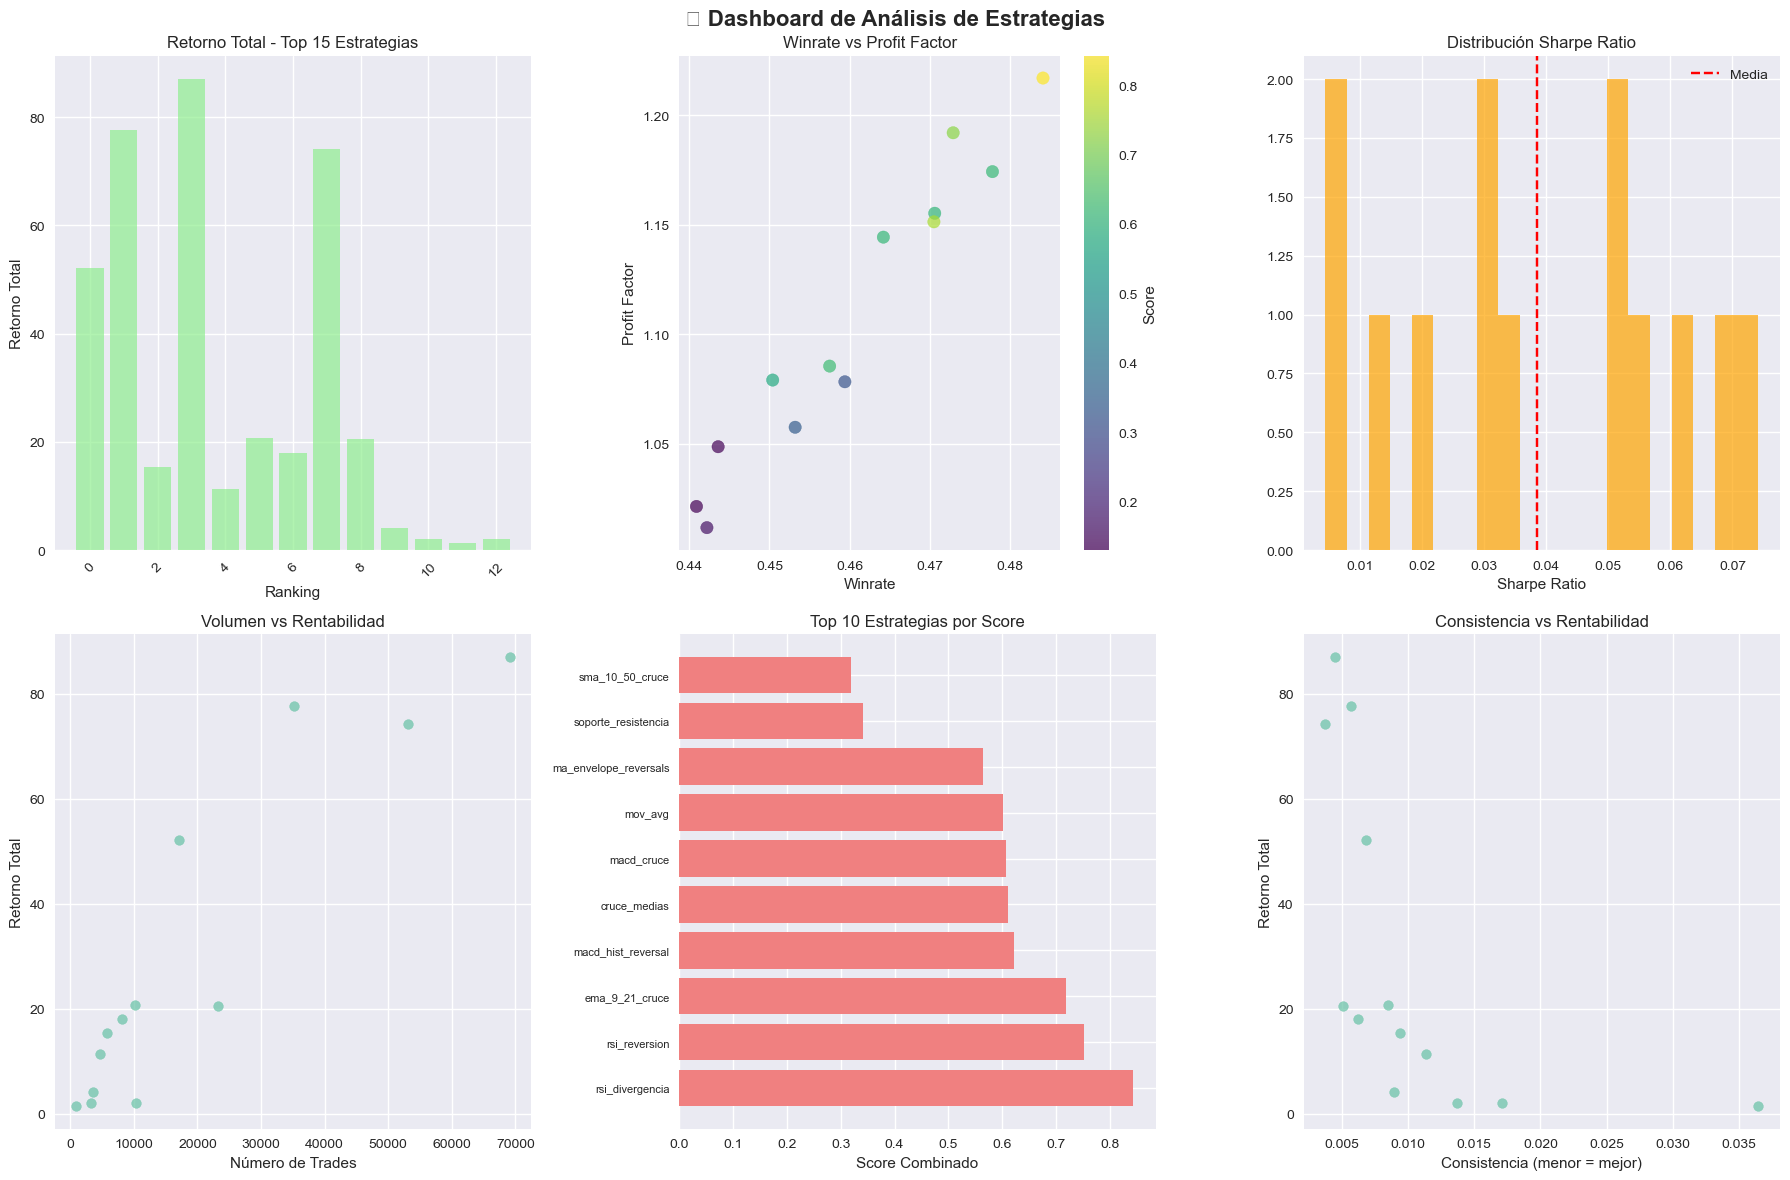


🔬 COMPARACIÓN DETALLADA - TOP 5 ESTRATEGIAS:

#1 - rsi_divergencia
   Score: 0.843
   Retorno Total: 52.197
   Winrate: 48.4%
   Profit Factor: 1.22
   Trades: 17032
   Símbolos: 50
   Avg Win: 0.0355
   Avg Loss: 0.0274

#2 - rsi_reversion
   Score: 0.751
   Retorno Total: 77.592
   Winrate: 47.0%
   Profit Factor: 1.15
   Trades: 35166
   Símbolos: 50
   Avg Win: 0.0357
   Avg Loss: 0.0276

#3 - ema_9_21_cruce
   Score: 0.717
   Retorno Total: 15.430
   Winrate: 47.3%
   Profit Factor: 1.19
   Trades: 5767
   Símbolos: 50
   Avg Win: 0.0351
   Avg Loss: 0.0264

#4 - macd_hist_reversal
   Score: 0.621
   Retorno Total: 87.048
   Winrate: 45.8%
   Profit Factor: 1.09
   Trades: 69093
   Símbolos: 50
   Avg Win: 0.0350
   Avg Loss: 0.0272

#5 - cruce_medias
   Score: 0.611
   Retorno Total: 11.326
   Winrate: 47.8%
   Profit Factor: 1.17
   Trades: 4632
   Símbolos: 50
   Avg Win: 0.0345
   Avg Loss: 0.0269

✅ VARIABLES CREADAS:
• ranking_estrategias: DataFrame completo con todas las m

In [6]:
# === ANÁLISIS COMPLETO DE ESTRATEGIAS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

print("🔄 Analizando estrategias...")

# === 1. MÉTRICAS BÁSICAS POR ESTRATEGIA ===
metricas_estrategias = df.groupby('estrategia').agg({
    'retorno': [
        'count',      # número de trades
        'sum',        # retorno total
        'mean',       # retorno promedio
        'median',     # retorno mediano
        'std',        # volatilidad
        lambda x: (x > 0).sum(),  # trades ganadores
        lambda x: (x <= 0).sum(), # trades perdedores
        lambda x: (x > 0).mean(), # winrate
        lambda x: x[x > 0].sum(), # ganancias totales
        lambda x: abs(x[x < 0].sum()), # pérdidas totales
        'max',        # mejor trade
        'min'         # peor trade
    ],
    'simbolo': 'nunique'  # número de símbolos únicos
}).round(4)

# Aplanar nombres de columnas
metricas_estrategias.columns = [
    'num_trades', 'retorno_total', 'retorno_promedio', 'retorno_mediano', 
    'volatilidad', 'trades_ganadores', 'trades_perdedores', 'winrate',
    'ganancias_totales', 'perdidas_totales', 'mejor_trade', 'peor_trade', 'num_simbolos'
]

# === 2. MÉTRICAS AVANZADAS ===
metricas_estrategias['profit_factor'] = (
    metricas_estrategias['ganancias_totales'] / 
    metricas_estrategias['perdidas_totales'].replace(0, np.nan)
)

metricas_estrategias['sharpe_ratio'] = (
    metricas_estrategias['retorno_promedio'] / metricas_estrategias['volatilidad']
)

metricas_estrategias['avg_win'] = (
    metricas_estrategias['ganancias_totales'] / 
    metricas_estrategias['trades_ganadores'].replace(0, np.nan)
)

metricas_estrategias['avg_loss'] = (
    metricas_estrategias['perdidas_totales'] / 
    metricas_estrategias['trades_perdedores'].replace(0, np.nan)
)

metricas_estrategias['reward_risk_ratio'] = (
    metricas_estrategias['avg_win'] / metricas_estrategias['avg_loss']
)

# Calcular percentil 90 y 10 para drawdown aproximado
def calc_percentiles(grupo):
    return pd.Series({
        'percentil_90': grupo['retorno'].quantile(0.9),
        'percentil_10': grupo['retorno'].quantile(0.1),
        'rango_retornos': grupo['retorno'].quantile(0.9) - grupo['retorno'].quantile(0.1)
    })

percentiles = df.groupby('estrategia').apply(calc_percentiles)
metricas_estrategias = metricas_estrategias.join(percentiles)

# === 3. SCORE COMBINADO ===
def normalizar_metrica(serie, invertir=False):
    """Normaliza métrica entre 0-1"""
    if serie.isna().all():
        return serie * 0
    
    norm = (serie - serie.min()) / (serie.max() - serie.min())
    return (1 - norm) if invertir else norm

# Filtrar estrategias con al menos 20 trades
estrategias_validas = metricas_estrategias.query('num_trades >= 20').copy()

estrategias_validas['score'] = (
    0.25 * normalizar_metrica(estrategias_validas['retorno_total']) +
    0.20 * normalizar_metrica(estrategias_validas['sharpe_ratio'].fillna(0)) +
    0.15 * normalizar_metrica(estrategias_validas['winrate']) +
    0.15 * normalizar_metrica(estrategias_validas['profit_factor'].fillna(1)) +
    0.10 * normalizar_metrica(estrategias_validas['reward_risk_ratio'].fillna(1)) +
    0.10 * normalizar_metrica(estrategias_validas['num_simbolos']) +
    0.05 * normalizar_metrica(estrategias_validas['volatilidad'], invertir=True)
)

# Ordenar por score
ranking_estrategias = estrategias_validas.sort_values('score', ascending=False).reset_index()

# === 4. MOSTRAR RESULTADOS ===
print("="*80)
print("📊 ANÁLISIS DE ESTRATEGIAS DE TRADING")
print("="*80)

print(f"Total estrategias analizadas: {len(metricas_estrategias)}")
print(f"Estrategias válidas (≥20 trades): {len(estrategias_validas)}")
print(f"Total operaciones: {df.shape[0]:,}")

print(f"\n🏆 TOP 10 ESTRATEGIAS:")
cols_display = [
    'estrategia', 'score', 'retorno_total', 'winrate', 'profit_factor', 
    'sharpe_ratio', 'num_trades', 'num_simbolos'
]
print(ranking_estrategias[cols_display].head(10).to_string(index=False, float_format='%.3f'))

print(f"\n📈 ESTADÍSTICAS GENERALES:")
print(f"Winrate promedio: {estrategias_validas['winrate'].mean():.1%}")
print(f"Profit Factor promedio: {estrategias_validas['profit_factor'].mean():.2f}")
print(f"Sharpe Ratio promedio: {estrategias_validas['sharpe_ratio'].mean():.2f}")
print(f"Retorno total promedio: {estrategias_validas['retorno_total'].mean():.3f}")

# === 5. ANÁLISIS DE CONSISTENCIA ===
print(f"\n🔍 ANÁLISIS DE CONSISTENCIA:")

# Calcular consistencia por estrategia (std de retornos por símbolo)
consistencia_estrategias = []
for estrategia in estrategias_validas.index:
    temp_df = df[df['estrategia'] == estrategia]
    if len(temp_df) > 0:
        retornos_por_simbolo = temp_df.groupby('simbolo')['retorno'].mean()
        consistencia = retornos_por_simbolo.std() if len(retornos_por_simbolo) > 1 else 0
        consistencia_estrategias.append({
            'estrategia': estrategia,
            'consistencia': consistencia,
            'simbolos_unicos': len(retornos_por_simbolo)
        })

consistencia_df = pd.DataFrame(consistencia_estrategias)
estrategias_validas = estrategias_validas.merge(
    consistencia_df.set_index('estrategia'), 
    left_index=True, right_index=True, how='left'
)

# Top 5 más consistentes (menor variabilidad = mejor)
top_consistentes = estrategias_validas.sort_values('consistencia').head(5)
print("Top 5 estrategias más consistentes:")
print(top_consistentes[['retorno_total', 'winrate', 'consistencia']].to_string(float_format='%.3f'))

# === 6. CREAR VISUALIZACIONES ===
def crear_dashboard_estrategias():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Dashboard de Análisis de Estrategias', fontsize=16, fontweight='bold')
    
    top_15 = ranking_estrategias.head(15)
    
    # 1. Retorno total por estrategia
    axes[0,0].bar(range(len(top_15)), top_15['retorno_total'], color='lightgreen', alpha=0.7)
    axes[0,0].set_title('Retorno Total - Top 15 Estrategias')
    axes[0,0].set_xlabel('Ranking')
    axes[0,0].set_ylabel('Retorno Total')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Winrate vs Profit Factor
    scatter = axes[0,1].scatter(
        estrategias_validas['winrate'], 
        estrategias_validas['profit_factor'].clip(0, 10),  # Limitar PF para visualización
        c=estrategias_validas['score'], 
        cmap='viridis', alpha=0.7, s=80
    )
    axes[0,1].set_xlabel('Winrate')
    axes[0,1].set_ylabel('Profit Factor')
    axes[0,1].set_title('Winrate vs Profit Factor')
    plt.colorbar(scatter, ax=axes[0,1], label='Score')
    
    # 3. Distribución de Sharpe Ratio
    axes[0,2].hist(estrategias_validas['sharpe_ratio'].dropna(), bins=20, alpha=0.7, color='orange')
    axes[0,2].axvline(estrategias_validas['sharpe_ratio'].mean(), color='red', linestyle='--', label='Media')
    axes[0,2].set_title('Distribución Sharpe Ratio')
    axes[0,2].set_xlabel('Sharpe Ratio')
    axes[0,2].legend()
    
    # 4. Número de trades vs Retorno
    axes[1,0].scatter(estrategias_validas['num_trades'], estrategias_validas['retorno_total'], alpha=0.7)
    axes[1,0].set_xlabel('Número de Trades')
    axes[1,0].set_ylabel('Retorno Total')
    axes[1,0].set_title('Volumen vs Rentabilidad')
    
    # 5. Top 10 por Score
    top_10_score = ranking_estrategias.head(10)
    bars = axes[1,1].barh(range(len(top_10_score)), top_10_score['score'], color='lightcoral')
    axes[1,1].set_title('Top 10 Estrategias por Score')
    axes[1,1].set_xlabel('Score Combinado')
    axes[1,1].set_yticks(range(len(top_10_score)))
    axes[1,1].set_yticklabels(top_10_score['estrategia'], fontsize=8)
    
    # 6. Consistencia vs Retorno
    axes[1,2].scatter(estrategias_validas['consistencia'], estrategias_validas['retorno_total'], alpha=0.7)
    axes[1,2].set_xlabel('Consistencia (menor = mejor)')
    axes[1,2].set_ylabel('Retorno Total')
    axes[1,2].set_title('Consistencia vs Rentabilidad')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Crear visualizaciones
dashboard_fig = crear_dashboard_estrategias()

# === 7. COMPARACIÓN DETALLADA TOP 5 ===
print(f"\n🔬 COMPARACIÓN DETALLADA - TOP 5 ESTRATEGIAS:")
print("="*80)

top_5_estrategias = ranking_estrategias.head(5)
for idx, (_, estrategia) in enumerate(top_5_estrategias.iterrows(), 1):
    print(f"\n#{idx} - {estrategia['estrategia']}")
    print(f"   Score: {estrategia['score']:.3f}")
    print(f"   Retorno Total: {estrategia['retorno_total']:.3f}")
    print(f"   Winrate: {estrategia['winrate']:.1%}")
    print(f"   Profit Factor: {estrategia['profit_factor']:.2f}")
    print(f"   Trades: {estrategia['num_trades']:.0f}")
    print(f"   Símbolos: {estrategia['num_simbolos']:.0f}")
    print(f"   Avg Win: {estrategia['avg_win']:.4f}")
    print(f"   Avg Loss: {estrategia['avg_loss']:.4f}")

# === 8. CREAR VARIABLES ÚTILES ===
# Lista de mejores estrategias
top_10_estrategias_lista = ranking_estrategias.head(10)['estrategia'].tolist()
top_5_estrategias_lista = ranking_estrategias.head(5)['estrategia'].tolist()

# DataFrame filtrado con mejores estrategias
df_top_estrategias = df[df['estrategia'].isin(top_10_estrategias_lista)].copy()

print(f"\n✅ VARIABLES CREADAS:")
print(f"• ranking_estrategias: DataFrame completo con todas las métricas")
print(f"• top_10_estrategias_lista: Lista con nombres de top 10 estrategias")
print(f"• top_5_estrategias_lista: Lista con nombres de top 5 estrategias")
print(f"• df_top_estrategias: DataFrame filtrado con solo top 10 estrategias")
print(f"• metricas_estrategias: Métricas completas de todas las estrategias")

print(f"\nDataFrame filtrado tiene {len(df_top_estrategias):,} operaciones de {df_top_estrategias['estrategia'].nunique()} estrategias")

In [16]:
import json

# Lista de simbolos top 50
simbolos_top50 = top50["simbolo"].dropna().unique().tolist()

# Dividir en grupos de hasta 5 simbolos
grupos = {
    f"grupo_{i+1}": simbolos_top50[i:i+5]
    for i in range(0, len(simbolos_top50), 5)
}

# Guardar archivo en carpeta config/
ruta_salida = "config/symbol_50.json"
with open(ruta_salida, "w") as f:
    json.dump(grupos, f, indent=2)

print(f"Archivo symbol_50.json generado con {len(grupos)} grupos en formato compatible con ing.py")



Archivo symbol_50.json generado con 10 grupos en formato compatible con ing.py
